In [1]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [2]:
multiclass_train = pd.read_csv("multiclass_train.csv")
multiclass_test = pd.read_csv("multiclass_test.csv")

In [3]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass_train[" Label"] = le.fit_transform(multiclass_train[" Label"].values)

multiclass_test[" Label"] = le.transform(multiclass_test[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass_train[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [4]:
y_train = multiclass_train[" Label"].copy()
X_train = multiclass_train.drop([" Label"], axis=1)

y_test = multiclass_test[" Label"].copy()
X_test = multiclass_test.drop([" Label"], axis=1)

In [5]:
scal = StandardScaler()
scal = scal.fit(X_train)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, stratify=y_train, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [6]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), 1, n_feat))
X_vl = np.reshape(X_val, (len(X_val), 1, n_feat))
X_tst = np.reshape(X_test, (len(X_test), 1, n_feat))

In [7]:
print(X_tr.shape)
print(y_train.shape)

(129838, 1, 80)
(129838,)


In [8]:
model = keras.Sequential()
model.add(keras.Input(shape=(1, n_feat)))
model.add(LSTM(512, activation=tfa.activations.gelu, return_sequences=True))
#model.add(LSTM(256, activation=tfa.activations.gelu, return_sequences=True))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation=tfa.activations.gelu))
model.add(Dense(64, activation=tfa.activations.gelu))
model.add(Dense(32, activation=tfa.activations.gelu))
model.add(Dense(12, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1214464   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 1,364,716
Trainable params: 1,364,716
Non-

In [9]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=512, epochs=50, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/50
254/254 [==============================] - 6s 13ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.7735 - val_sparse_categorical_accuracy: 0.6746 - lr: 0.0010
Epoch 2/50
254/254 [==============================] - 3s 11ms/step - loss: 0.7374 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.7307 - val_sparse_categorical_accuracy: 0.6904 - lr: 0.0010
Epoch 3/50
254/254 [==============================] - 3s 11ms/step - loss: 0.7072 - sparse_categorical_accuracy: 0.6957 - val_loss: 0.7107 - val_sparse_categorical_accuracy: 0.6937 - lr: 0.0010
Epoch 4/50
254/254 [==============================] - 3s 11ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.7023 - val_sparse_categorical_accuracy: 0.6980 - lr: 0.0010
Epoch 5/50
254/254 [==============================] - 3s 11ms/step - loss: 0.6822 - sparse_categorical_accuracy: 0.7044 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.7008 - lr: 0.0010
Epoch 6/50
254/254 [==========

In [10]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "LSTM_multi_final.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


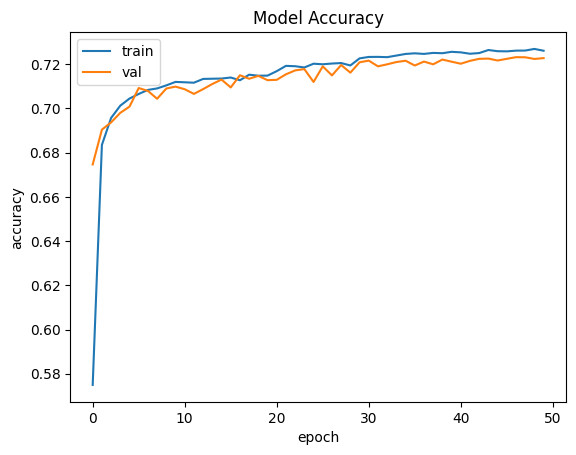

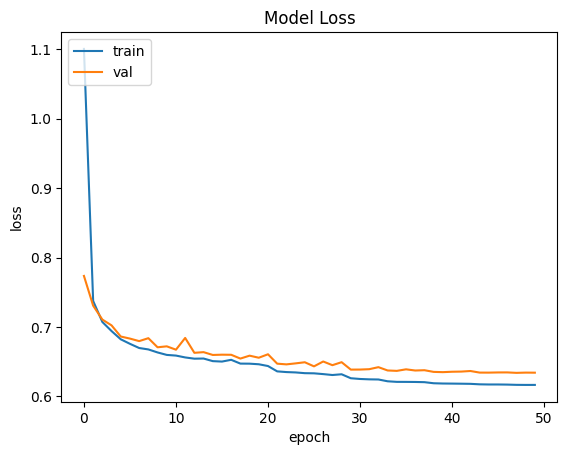

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
#Test predictions
#model.load_weights(checkpoint_filepath)
prediction = model.predict(X_tst)

1160/1160 [==============================] - 3s 2ms/step


In [13]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

2     4626
1     3628
6     3614
5     3570
7     3481
10    3330
3     3132
9     3078
8     2985
11    2472
4     1681
0     1500
dtype: int64

In [14]:
print(classification_report(y_test.to_numpy(), pred, digits=6,target_names=multiclass_labels))

              precision    recall  f1-score   support

         DNS   0.638000  0.309609  0.416903      3091
        LDAP   0.576351  0.676480  0.622414      3091
       MSSQL   0.606139  0.907150  0.726707      3091
         NTP   0.972542  0.985123  0.978792      3092
     NetBIOS   0.830458  0.451488  0.584957      3092
     Portmap   0.739216  0.853769  0.792374      3091
        SNMP   0.639181  0.747089  0.688935      3092
        SSDP   0.452169  0.509056  0.478929      3092
         Syn   0.998995  0.964736  0.981567      3091
        TFTP   0.999350  0.995147  0.997244      3091
         UDP   0.486186  0.523779  0.504283      3091
     UDP-lag   0.948220  0.758085  0.842559      3092

    accuracy                       0.723455     37097
   macro avg   0.740567  0.723459  0.717972     37097
weighted avg   0.740571  0.723455  0.717972     37097



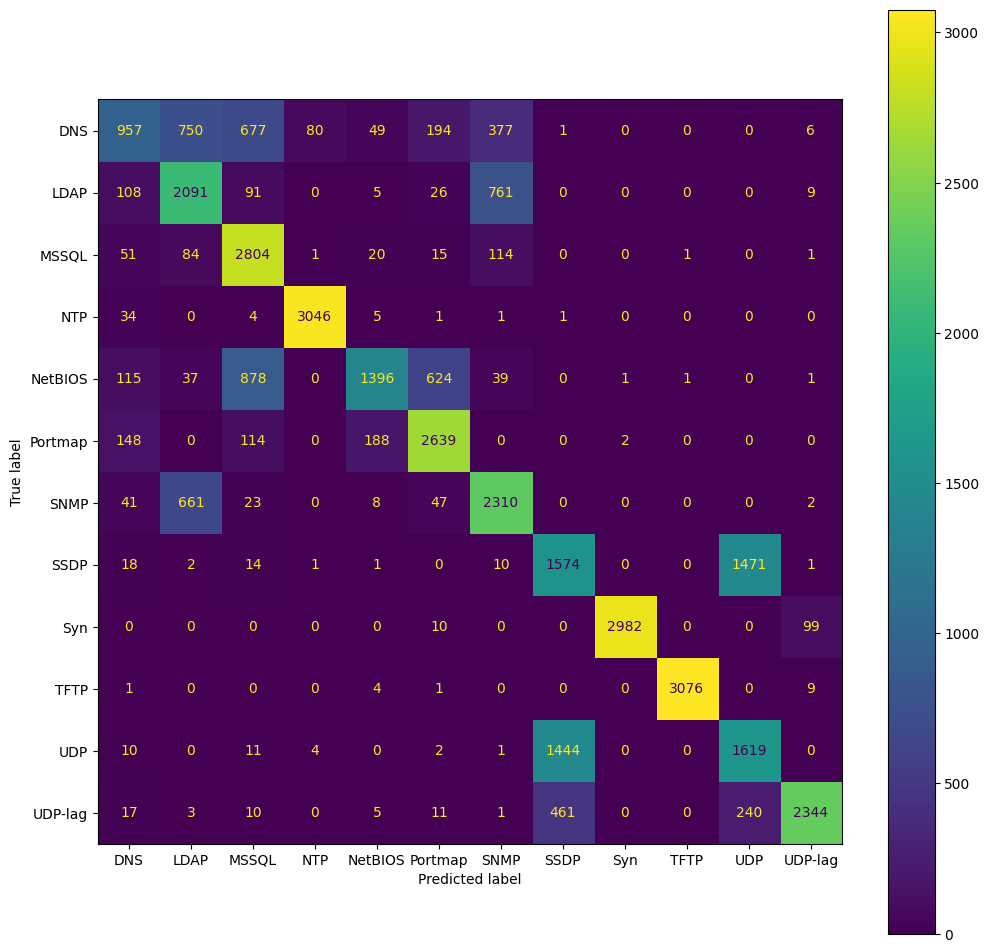

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_multi_lstm.png")